---
# Object Detection/Localizator
---
## Tasks Outline:

#### Idea: start with the most basic task, gradually make it more complex 
* Step 1) identify actual boxes
* Step 2) locate an actual object (a Pokemon)
* Step 3) different sized objects
* Step 4) flipped objects
* Step 5) add actual backgrounds 
* Step 6) object may not appear 
* Step 7) multiple classes of objects

---
---
# Step 1) identify actual boxes
---
---

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


2.10.0


In [2]:
vgg = tf.keras.applications.VGG16(input_shape=[100, 100, 3],
                                  include_top=False,
                                  weights='imagenet')

In [3]:
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

In [4]:
def image_generator(batch_size=64):
    # generate image and targets
    while True:
        for _ in range(50): # Each epoch will have 50 batches. (No important reason)
            X = np.zeros((batch_size, 100, 100, 3)) #100x100 images with rgb
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size): #make boxes and store their location in the target
                row0 = np.random.randint(90)
                col0 = np.random.randint(90)
                row1 = np.random.randint(row0, 90) #row0<row1 #no negative dimensions
                col1 = np.random.randint(col0, 90) #col0<col1
                #Create input (X):
                X[i,row0:row1,col0:col1,:]=1 #i'th element in the batch, between row&cols and every RGB = 1
                #Create output/Targets (Y):
                Y[i,0] = row0/100.        #top left corner(x1) + normalization
                Y[i,1] = col0/100.        #top left corner(y1) + normalization
                Y[i,2] = (row1-row0)/100. #bottom right corner(x2) + normalization
                Y[i,3] = (col1-col0)/100. #bottom right corner(y2) + normalization
        yield X, Y # instead of return we use yield

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001))

c:\Users\Giray\Coding_Courses\Ai\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
model.fit(
    x=image_generator(batch_size=64),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 13s 246ms/step - loss: 0.6797
Epoch 2/5
50/50 [==============================] - 12s 239ms/step - loss: 0.5311
Epoch 3/5
50/50 [==============================] - 12s 240ms/step - loss: 0.4952
Epoch 4/5
50/50 [==============================] - 12s 241ms/step - loss: 0.4926
Epoch 5/5
50/50 [==============================] - 12s 237ms/step - loss: 0.4951


In [7]:
from matplotlib.patches import Rectangle

# Make predictions

def make_prediction():
    #generate random img
    x = np.zeros((100,100,3)) #create background
    #create box
    row0 = np.random.randint(90)
    col0 = np.random.randint(90)
    row1 = np.random.randint(row0,100)
    col1 = np.random.randint(col0,100)
    x[row0:row1,col0:col1,:] = 1
    print((row0, col0, row1, col1))

    #Predict
    X= np.expand_dims(x, 0) # batch_size = 0
    p = model.predict(X)[0] # prediction has batch_size of 1, we can select first idx

    #Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x)
    rect = Rectangle((p[1]*100, p[0]*100), #matplotlib wants unnormalized coordinates, and also in a different order.
                      p[3]*100,
                      p[2]*100,
                      linewidth=1,
                      edgecolor="r",
                      facecolor='None')
    ax.add_patch(rect)
    plt.show()

(12, 19, 85, 48)
1/1 [==============================] - 0s 19ms/step


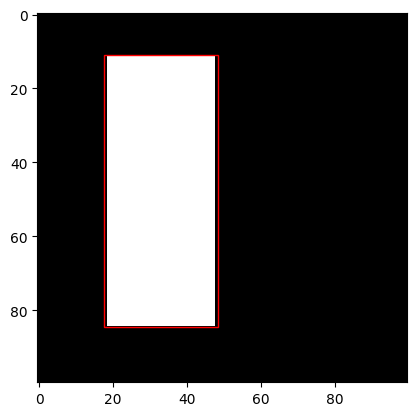

(65, 74, 76, 88)
1/1 [==============================] - 0s 19ms/step


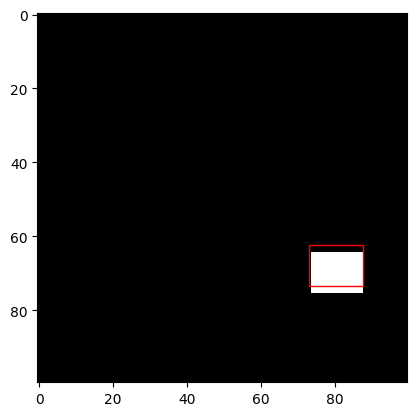

(18, 37, 54, 41)
1/1 [==============================] - 0s 19ms/step


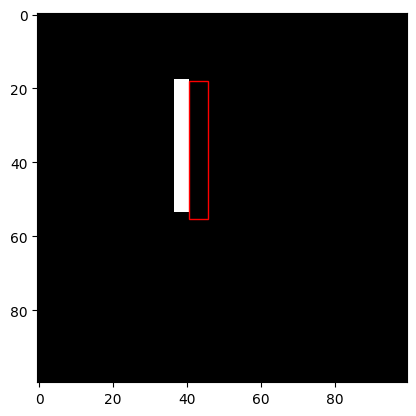

(84, 40, 88, 96)
1/1 [==============================] - 0s 18ms/step


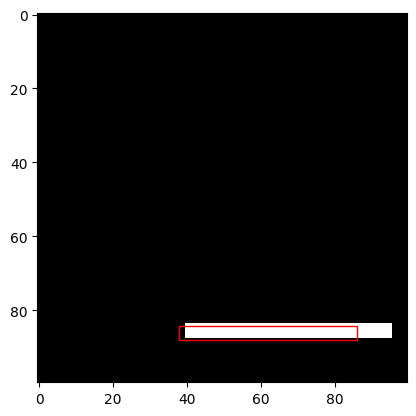

(61, 20, 79, 36)
1/1 [==============================] - 0s 19ms/step


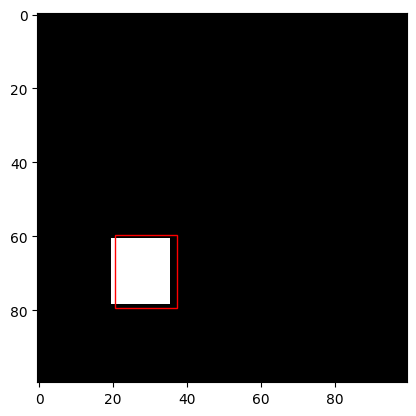

In [10]:
for i in range(5):
    make_prediction()

---
---
# Step 2) locate an actual object (a Pokemon)
---
---

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load image method 1:
from tensorflow.keras.preprocessing import image

(56, 44, 3)
<class 'PIL.Image.Image'>


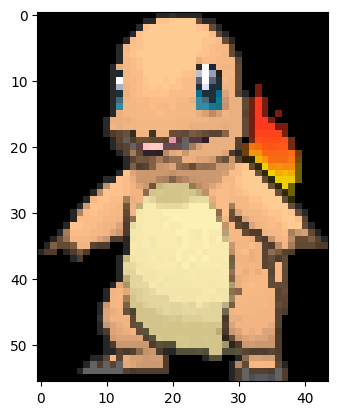

In [4]:
# object is in the tightest box possible
ch = image.load_img('charmander-tight.png')
plt.imshow(ch)

print(np.array(ch).shape)
print(type(ch))
# background is black, RGB

In [5]:
# load image method 2:
import imageio.v2 as imageio

(56, 44, 4)
<class 'numpy.ndarray'>


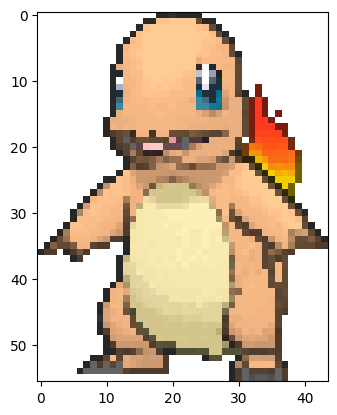

In [6]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)

print(np.array(ch).shape)
print(type(ch))
# background is white, RGBA

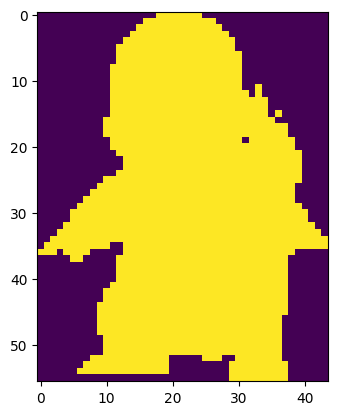

In [7]:
#plot alpha channel, (4th channel)
plt.imshow(ch[:,:,3])
plt.show()

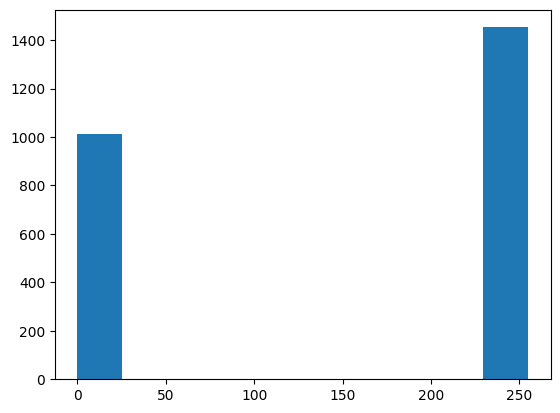

{0, 255}

In [8]:
plt.hist(ch[:,:,3].flatten()) # check possible pixel values by histogram
plt.show()

set(ch[:,:,3].flatten()) # see 1 possible value per element with set

In [9]:
# image generator
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape
print(CH_H, CH_W, _)

def pokemon_generator(batch_size=64):
    # generate image and targets
    while True:
        for _ in range(50): # Each epoch will have 50 batches. (No important reason)
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3)) #POKE_DIMxPOKE_DIM images with rgb
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size): #make boxes and store their location in the target
                row0 = np.random.randint(POKE_DIM - CH_H) # CH has fixed size.
                col0 = np.random.randint(POKE_DIM - CH_W)
                row1 = row0 + CH_H
                col1 = col0 + CH_W
                #Create input (X):
                X[i,row0:row1,col0:col1,:]= ch[:,:,:3] #i'th element in the batch
                #Create output/Targets (Y):
                Y[i,0] = row0/POKE_DIM        #top left corner(x1) + normalization
                Y[i,1] = col0/POKE_DIM        #top left corner(y1) + normalization
                Y[i,2] = (row1-row0)/POKE_DIM #bottom right corner(x2) + normalization
                Y[i,3] = (col1-col0)/POKE_DIM #bottom right corner(y2) + normalization
        yield X / 255., Y # instead of return we use yield    

56 44 4
